# Estimate ΔG

In [1]:
from pathlib import Path
import os
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

from cinnabar import FEMap, plotlying, plotting #, stats

import utils

In [2]:
def ddG_2_dG(edge_df: pd.DataFrame, exp_df: pd.DataFrame, protein_df: pd.DataFrame, water_df: pd.DataFrame, output_csv: Path|str = "/dev/shm/tmp.csv"):
    """
    Prepare a CSV file for Cinnabar Cycle Closure.
    
    Parameters
    ----------
    edge_df :
        This DataFrame should contain edge_name as index, and Lig_1, Lig_2

    exp_df : pd.DataFrame
        This DataFrame should contain Lig_Name as index, and Exp_dG

    protein_df :
        This DataFrame should contain edge_name as index, and ddG, ddG_err

    water_df :
        This DataFrame should contain edge_name as index, and ddG, ddG_err

    output_csv :
        Path to the temporary CSV file.

    """
    # ddG
    ddG_dict = {"edge_name"   :[],
                "calc_ddG"    :[],
                "calc_ddG_err":[],
                "Exp_ddG"     :[],
               }
    for edge_name in edge_df.index:
        ddG_dict["edge_name"   ].append(edge_name)
        ddG_dict["calc_ddG"    ].append(protein_df.loc[edge_name, "ddG"] - water_df.loc[edge_name, "ddG"])
        ddG_dict["calc_ddG_err"].append(np.sqrt(protein_df.loc[edge_name, "ddG_err"]**2 + water_df.loc[edge_name, "ddG_err"]**2))
        ddG_dict["Exp_ddG"     ].append(edge_df.loc[edge_name, "Exp_ddG"])
    ddG_df = pd.DataFrame(ddG_dict)
    ddG_df.set_index("edge_name")
    ddG_df["Err"] = ddG_df["Exp_ddG"] - ddG_df["calc_ddG"]
    
    # dG
    utils.prepare_cinnabar_csv(edge_df, exp_df, protein_df, water_df, output_csv)
    fe = FEMap.from_csv(output_csv)
    fe.generate_absolute_values()
    df_abs = fe.get_absolute_dataframe()

    df_abs_com = df_abs[df_abs["computational"]== True]
    df_abs_exp = df_abs[df_abs["computational"]== False]
    df_abs_com = df_abs_com.set_index("label")
    df_abs_exp = df_abs_exp.set_index("label")
    
    df_abs_com["DG (kcal/mol)"] += df_abs_exp.loc[df_abs_exp.index, "DG (kcal/mol)"].mean() - df_abs_com.loc[df_abs_exp.index, "DG (kcal/mol)"].mean()
    
    exp_list = []
    for lig in df_abs_com.index:
        if lig in df_abs_exp.index:
            exp_list.append(df_abs_exp.loc[lig, "DG (kcal/mol)"])
        else:
            exp_list.append(None)
    df_abs_com["Exp_dG"] = exp_list
    return df_abs_com, ddG_df

# 1. Load Data

In [3]:
# point this to your folder
base = Path("/home/chui/E29Project-2023-04-11/136-grandFEP/benchmark/08-Water-Set/Benchmark_waterSet_2025_10_01/sim")

dG_dict = {}
ddG_dict = {}

for system in ["hspw", "hspk"]:
    system_base = base / system
    
    edge_df = pd.read_csv(system_base / "edge.csv", index_col="edge_name")
    exp_df = pd.read_csv(system_base / "lig.csv", index_col="Lig_Name")
    
    for ff, sim_length_list in [("04_tip3p_REST2", [5, 10, 15]),
                                ("05_opc_REST2",   [5, 10, 15]   ),
                               ]: # ["tip3p_REST2", "opc_REST2"]
        # water leg
        reps = [f"{ff}/water/NPT/rep_{rep}/mbar/bar.log" for rep in range(3)]
        wat_df = utils.read_ddG_edges(edge_df.index, system_base, reps)
        
        # protein leg with different length of sampling
        for sim_length in sim_length_list:
            for prot in ["GC_80l_40MD_31RE_200MD"]: # "GC_80l_40MD_31RE_200MD", "GC_80l_40MD_15RE_200MD", "NPT_prod"
                reps = [f"{ff}/protein/{prot}/rep_{rep}/mbar_{sim_length}ns/mbar.log" for rep in range(3)]
                pro_df = utils.read_ddG_edges(edge_df.index, system_base, reps)
                dG_df, ddG_df = ddG_2_dG(edge_df,exp_df,pro_df,wat_df)
                dG_dict[ f"{system}_{ff}_{prot}_{sim_length}ns"] = dG_df
                ddG_dict[f"{system}_{ff}_{prot}_{sim_length}ns"] = ddG_df

/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWar

# 2. Bootstrap

In [4]:
def append_stat(dG_dict, name, rmsd, rmsd_bs, tau, tau_bs, rsq, rsq_bs):
    dG_dict["name"].append(name)
    dG_dict["RMSE"].append(rmsd)
    ci_l, ci_h = rmsd_bs.confidence_interval
    dG_dict["RMSE_lower"].append(ci_l)
    dG_dict["RMSE_upper"].append(ci_h)
    
    dG_dict["tau" ].append(tau)
    ci_l, ci_h = tau_bs.confidence_interval
    if np.any(np.isnan([ci_l, ci_h])):
        print(f"nan found in CI tau lower: {ci_l}, upper {ci_h}")
        dG_dict["tau_lower"].append(tau)
        dG_dict["tau_upper"].append(tau)
    else:
        dG_dict["tau_lower"].append(ci_l)
        dG_dict["tau_upper"].append(ci_h)

    dG_dict["rsq"].append(rsq)
    ci_l, ci_h = rsq_bs.confidence_interval
    if np.any(np.isnan([ci_l, ci_h])):
        print(f"nan found in CI R^2 lower: {ci_l}, upper {ci_h}")
        dG_dict["rsq_lower"].append(rsq)
        dG_dict["rsq_upper"].append(rsq)
    else:
        dG_dict["rsq_lower"].append(ci_l)
        dG_dict["rsq_upper"].append(ci_h)

In [5]:

dG_table = {
    "name"       : [],
    "RMSE"       : [],
    "RMSE_lower" : [],
    "RMSE_upper" : [],
    "tau"        : [],
    "tau_lower"  : [],
    "tau_upper"  : [],
    "rsq"        : [],
    "rsq_lower"  : [],
    "rsq_upper"  : [],
    
}
for name, df in dG_dict.items():
    print(f"Bootstrap {name} ...")
    (rmsd, rmsd_bs), (tau, tau_bs), (rsq, rsq_bs) = utils.get_stat(df["DG (kcal/mol)"], df["Exp_dG"], 
                                                             [utils.rmsd_stat,
                                                              utils.kendall_stat,
                                                              utils.r_squared_stat,
                                                             ])
    append_stat(dG_table, name, rmsd, rmsd_bs, tau, tau_bs, rsq, rsq_bs)
dG_table = pd.DataFrame(dG_table)
dG_table = dG_table.set_index("name")


Bootstrap hspw_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_5ns ...


/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/chui/E29Project-2023-04-11/136-grandFEP/GrandFEP/test/hspw_tutorial/analysis/utils.py:306: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = scipy.stats.bootstrap(
/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


nan found in CI tau lower: nan, upper nan
nan found in CI R^2 lower: nan, upper nan
Bootstrap hspw_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_10ns ...
nan found in CI tau lower: nan, upper nan
nan found in CI R^2 lower: nan, upper nan
Bootstrap hspw_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_15ns ...
nan found in CI tau lower: nan, upper nan
nan found in CI R^2 lower: nan, upper nan
Bootstrap hspw_05_opc_REST2_GC_80l_40MD_31RE_200MD_5ns ...
nan found in CI tau lower: nan, upper nan
nan found in CI R^2 lower: nan, upper nan
Bootstrap hspw_05_opc_REST2_GC_80l_40MD_31RE_200MD_10ns ...
nan found in CI tau lower: nan, upper nan
nan found in CI R^2 lower: nan, upper nan
Bootstrap hspw_05_opc_REST2_GC_80l_40MD_31RE_200MD_15ns ...
nan found in CI tau lower: nan, upper nan
nan found in CI R^2 lower: nan, upper nan
Bootstrap hspk_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_5ns ...
Bootstrap hspk_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_10ns ...
Bootstrap hspk_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_15ns ...
Bootstra

# 3. Plot

In [6]:
def label_stat(name_all, dG_table):
    for ax, name in name_all:
        rmsd = dG_table.loc[name, "RMSE"]
        ci_l = dG_table.loc[name, "RMSE_lower"]
        ci_h = dG_table.loc[name, "RMSE_upper"]
        text = r"$rmse={:.2f}^{{{:.2f}}}_{{{:.2f}}}$".format(rmsd, ci_h, ci_l)
        text += "\n"
        tau  = dG_table.loc[name, "tau"]
        ci_l = dG_table.loc[name, "tau_lower"]
        ci_h = dG_table.loc[name, "tau_upper"]
        text += r"$\tau={:.2f}^{{{:.2f}}}_{{{:.2f}}}$".format(tau, ci_h, ci_l)
        text += "\n"
        rsq  = dG_table.loc[name, "rsq"]
        ci_l = dG_table.loc[name, "rsq_lower"]
        ci_h = dG_table.loc[name, "rsq_upper"]
        text += r"$R^2={:.2f}^{{{:.2f}}}_{{{:.2f}}}$".format(rsq, ci_h, ci_l)
            
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.text(
            xmin + (xmax - xmin)*0.05, 
            ymax - (ymax - ymin)*0.05,
            text, 
            verticalalignment = "top",
            bbox=dict(facecolor='white', alpha=1.0)
           )

## 3.1. ΔG

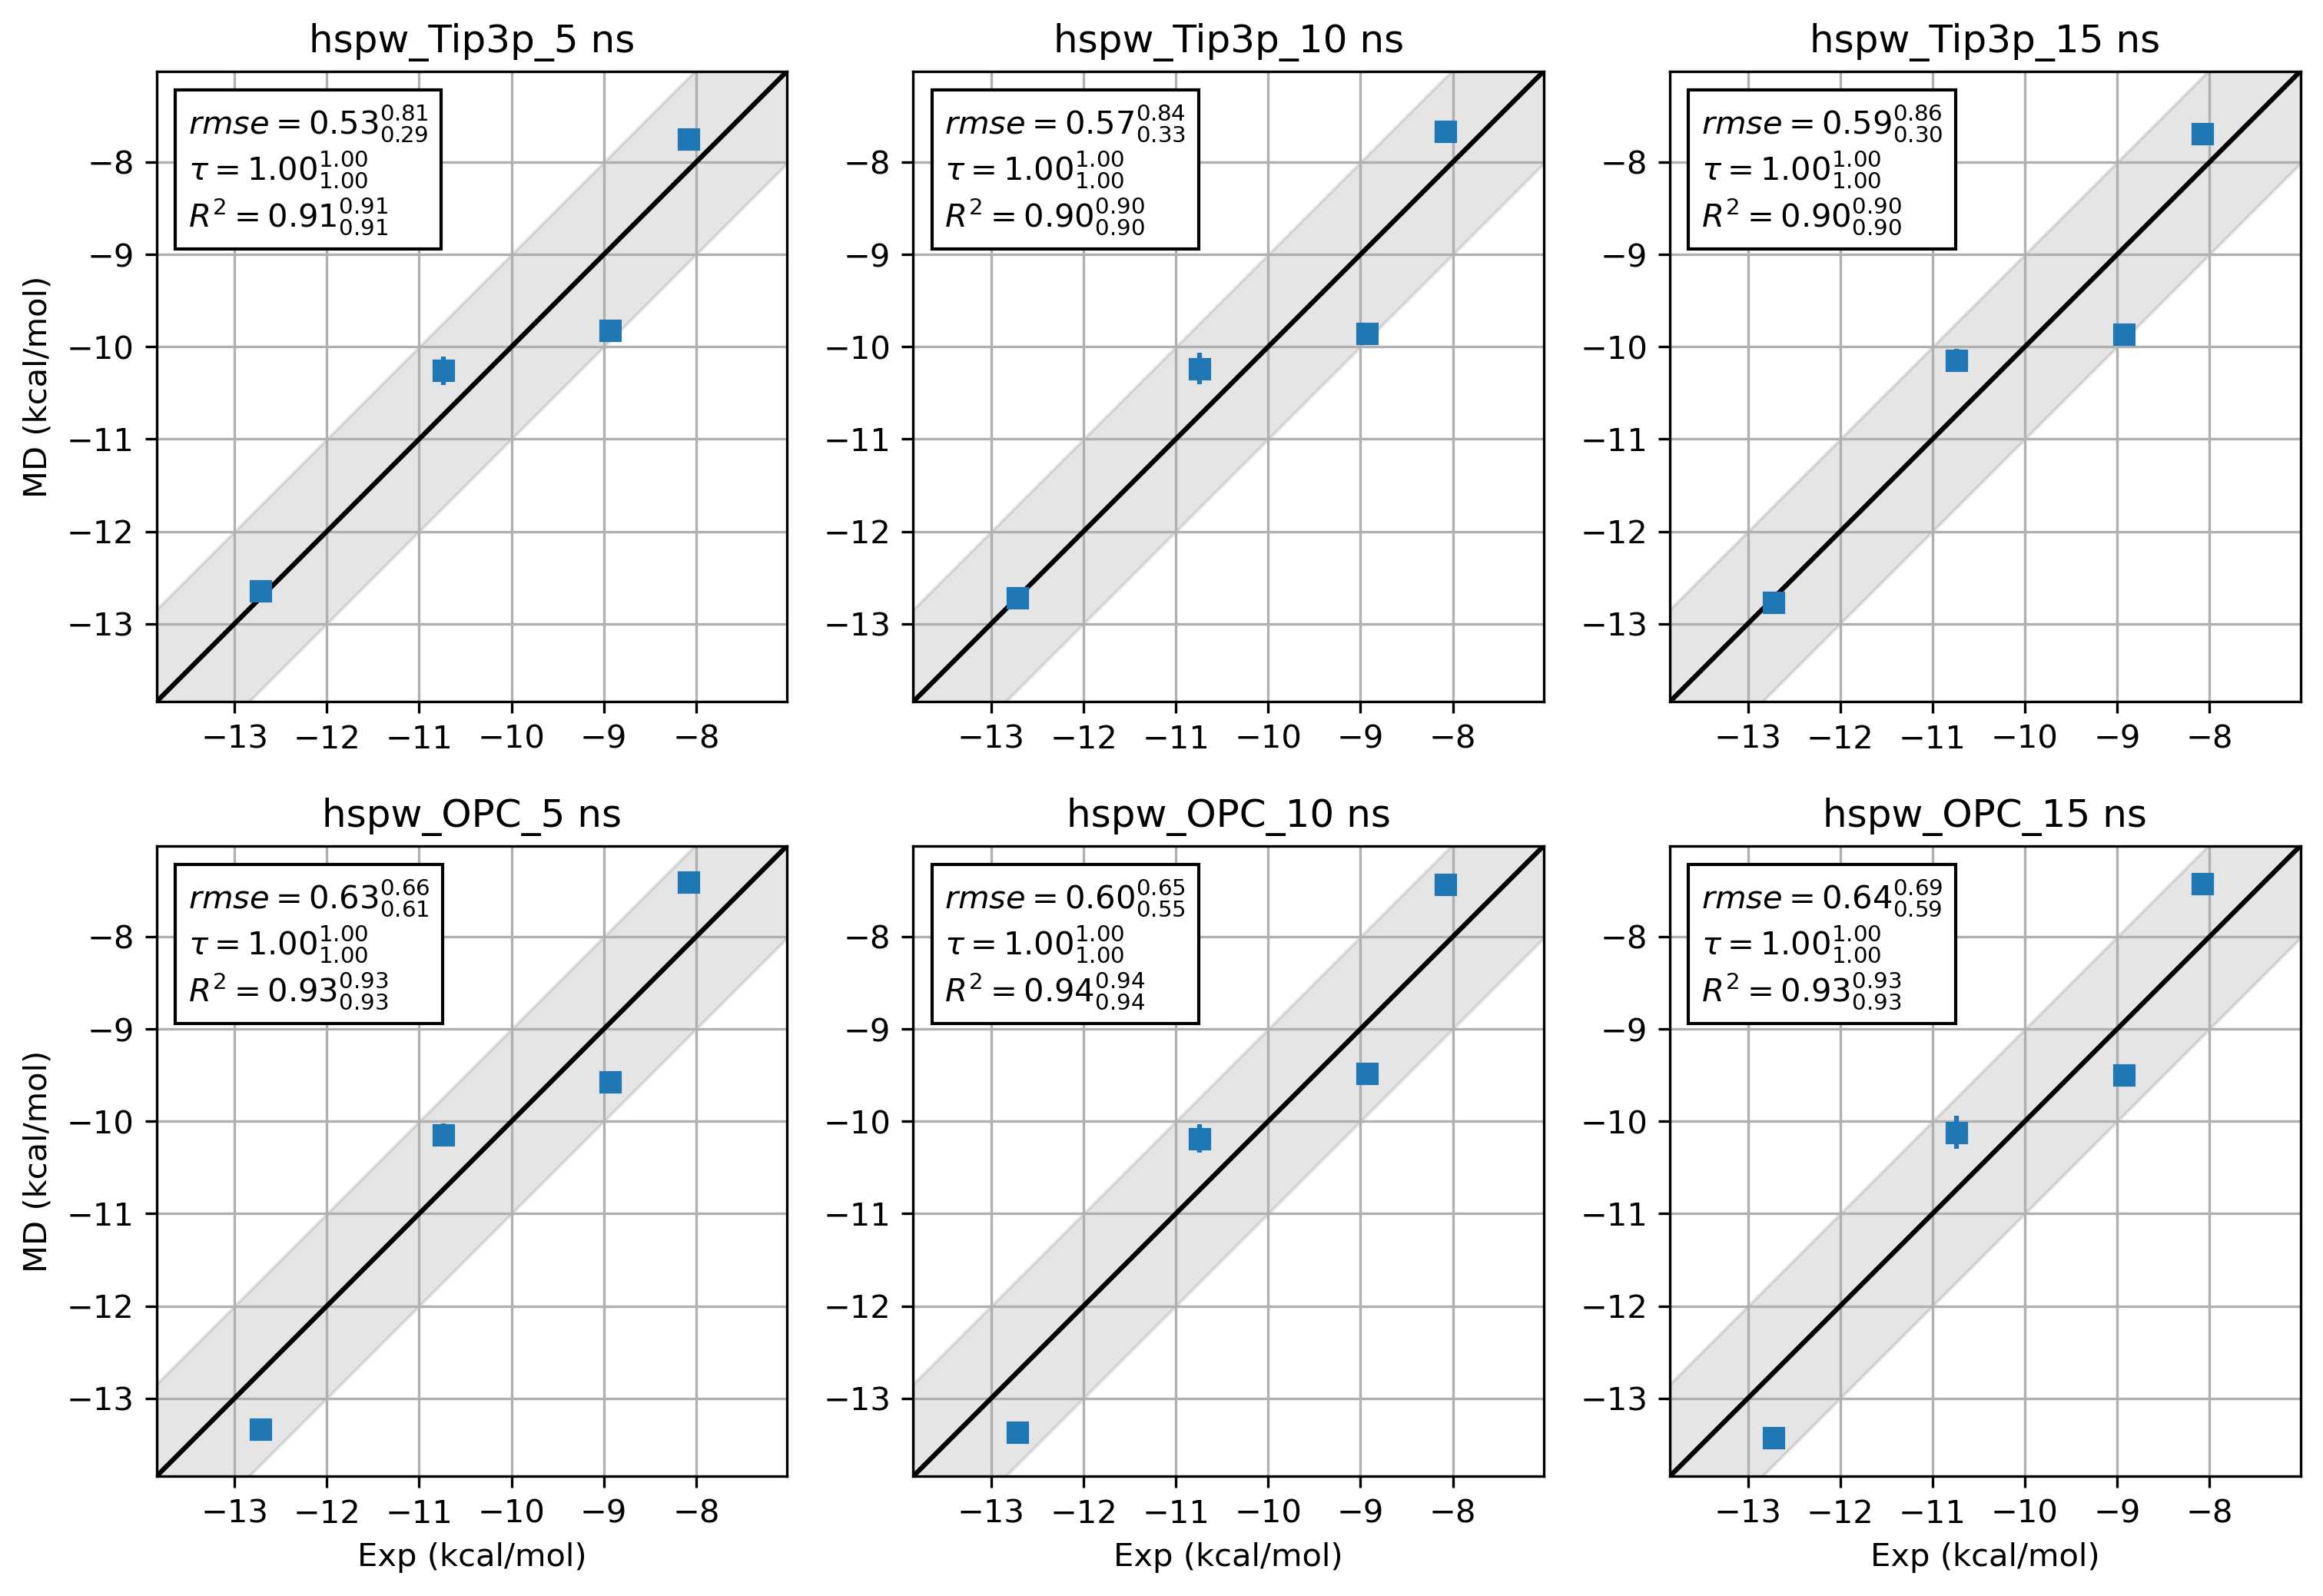

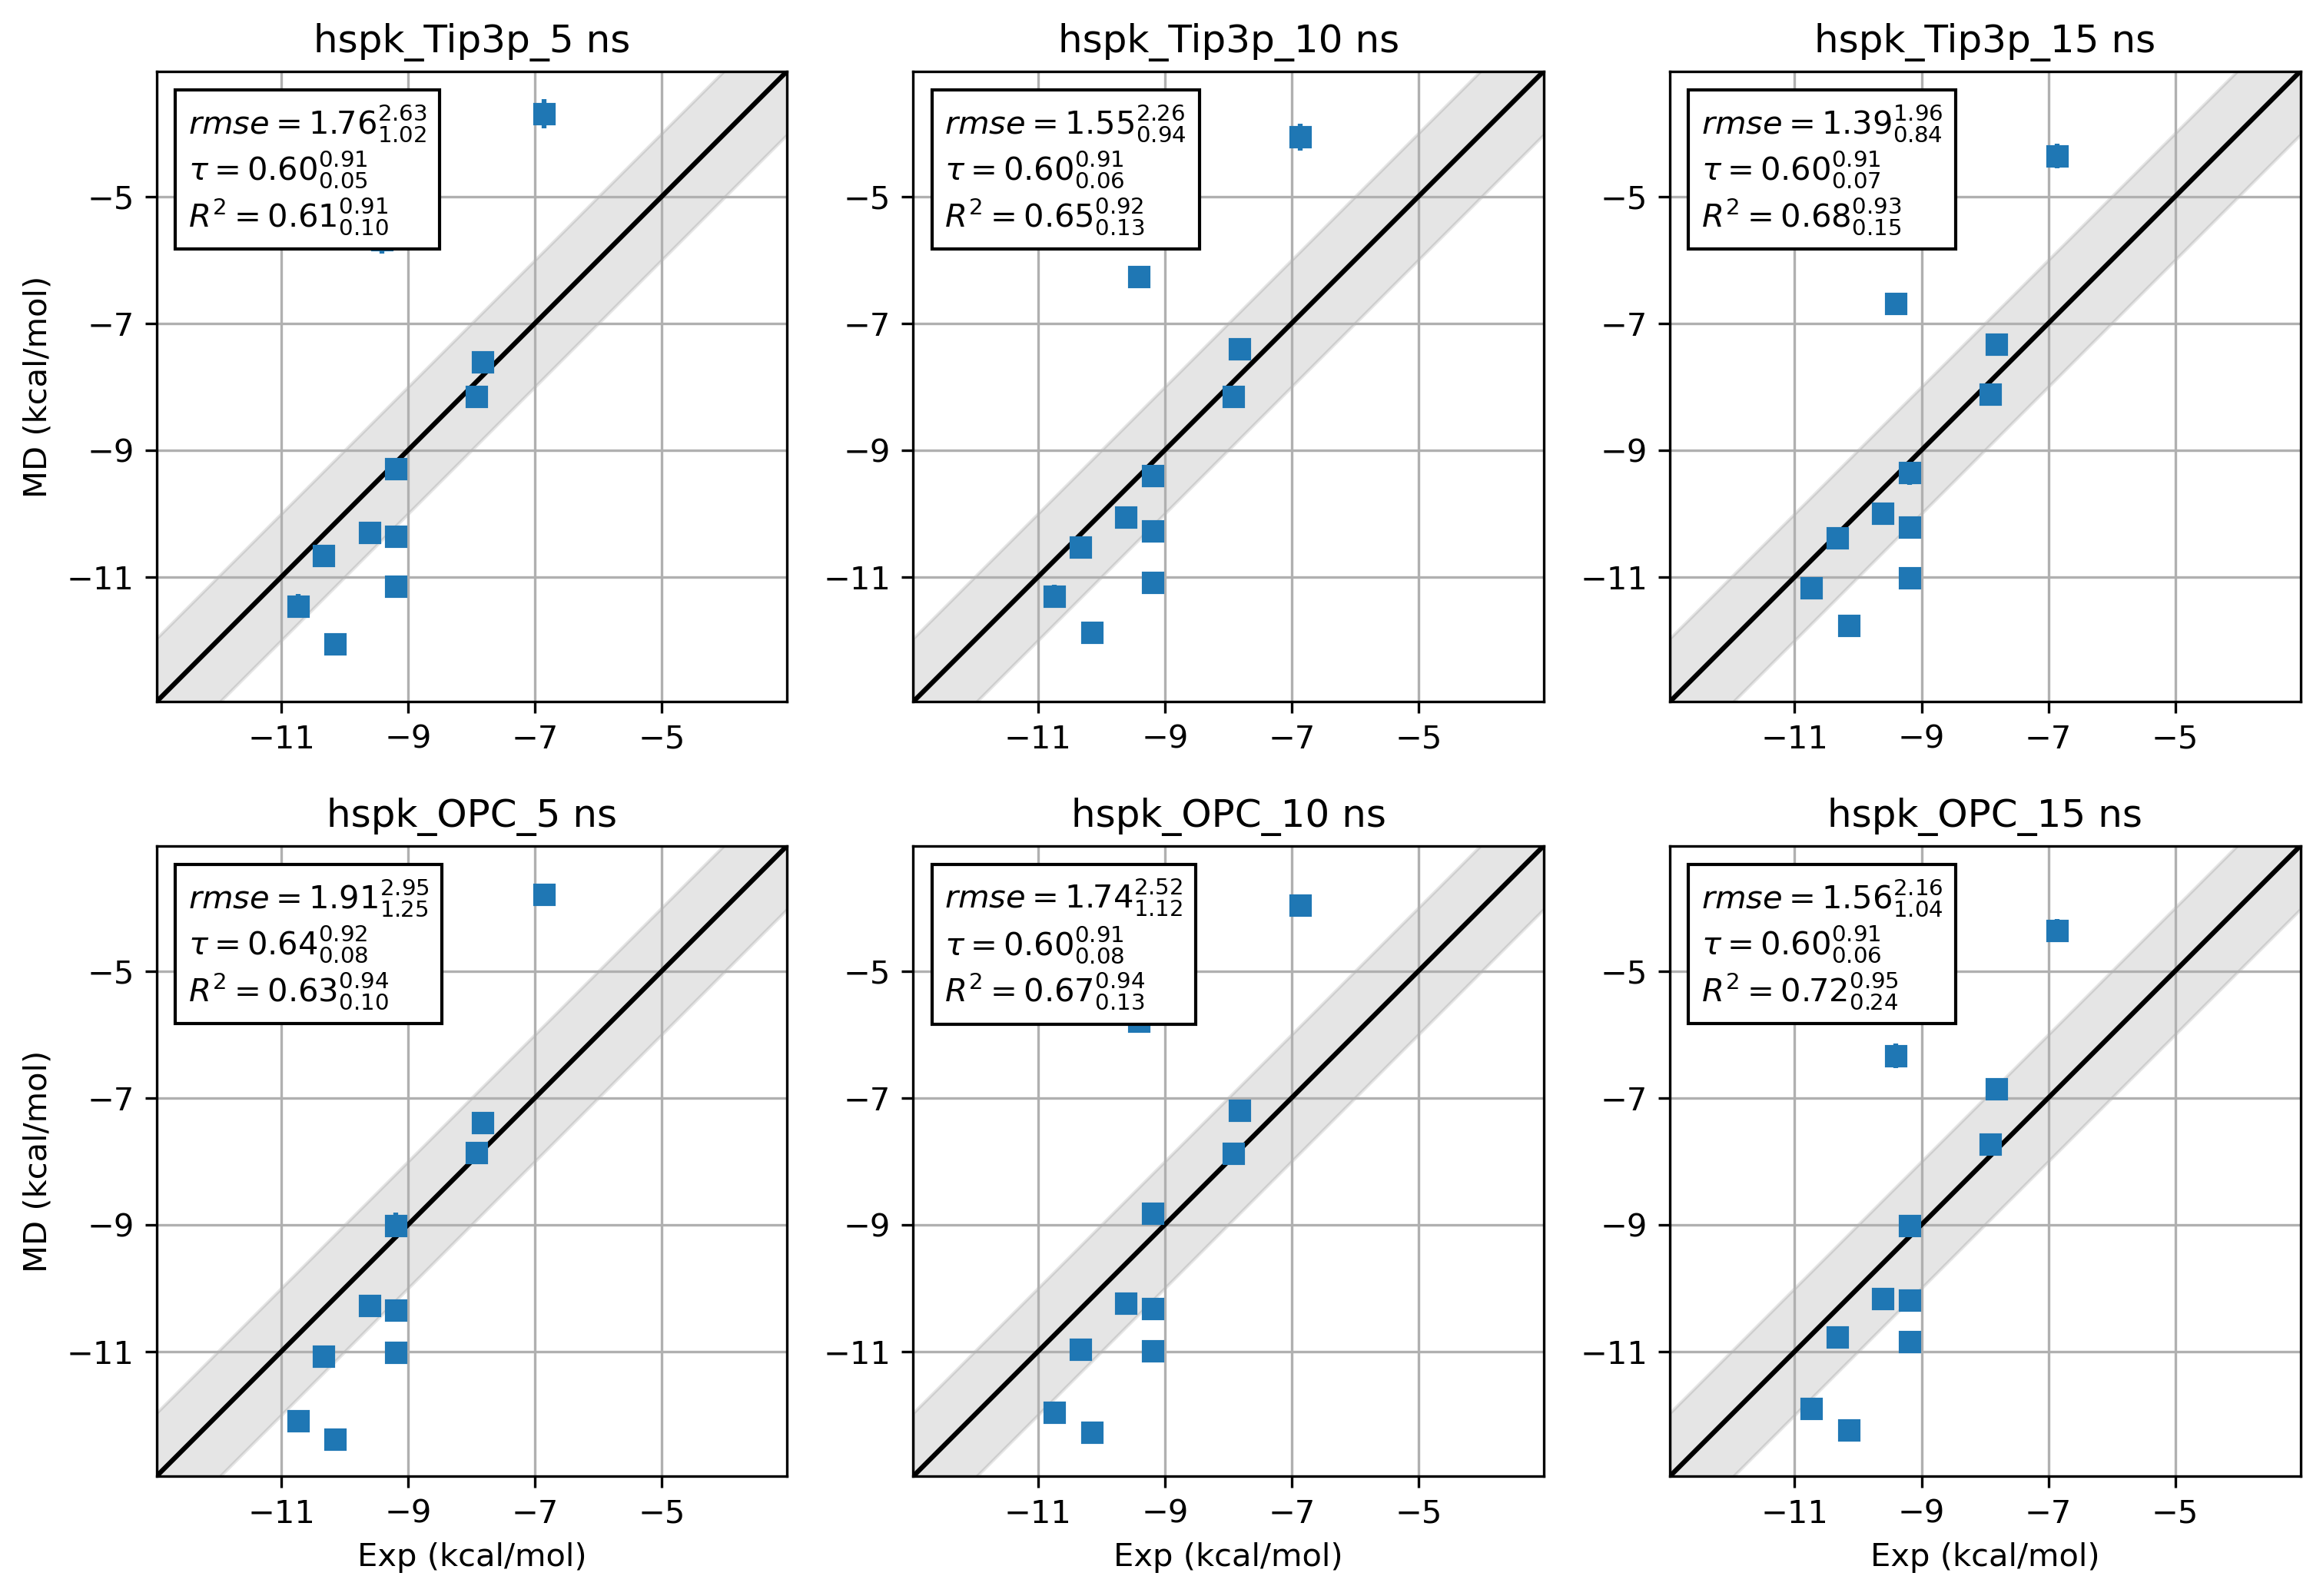

In [10]:
ff_title_dict = {
    "04_tip3p_REST2" : "Tip3p",
    "05_opc_REST2"   : "OPC",
}

for system in ["hspw", "hspk"]:
    fig, axes = plt.subplots(2,3,dpi=300, figsize=(12, 8))
    name_all = []
    prot = "GC_80l_40MD_31RE_200MD"
    for ff, ax_list in zip(["04_tip3p_REST2", "05_opc_REST2"], axes):
        for (ax, sim_length) in zip(ax_list, [5, 10, 15]):
            name = f"{system}_{ff}_{prot}_{sim_length}ns"
            if name in dG_dict:
                df = dG_dict[name]
                name_all.append((ax, name))
                ax.errorbar(df["Exp_dG"], df["DG (kcal/mol)"], yerr = df["uncertainty (kcal/mol)"], marker='s', ls='none')
                ax.grid()
                ax.set_title(f"{system}_{ff_title_dict[ff]}_{sim_length} ns")
            else:
                ax.set_xlim(-10, -9)
                ax.set_ylim(-10, -9)
            
    (xmax, xmin), (ymax, ymin) = utils.uniform_xylim(axes)
    label_stat(name_all, dG_table)
    utils.add_gray_1kcal(axes, alpha=0.1)

    for ax in axes[-1]:
        ax.set_xlabel("Exp (kcal/mol)")
    for ax_list in axes:
        ax_list[0].set_ylabel("MD (kcal/mol)")
    
    fig.savefig(f"{system}_deltaG.png", bbox_inches='tight')

## 2.2. ΔΔG

In [11]:
ddG_dict["hspw_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_15ns"]


,edge_name,calc_ddG,calc_ddG_err,Exp_ddG,Err
0,edge_1_to_4,2.954900,0.054861,3.79,0.835100
1,edge_4_to_3,2.192533,0.031984,0.85,-1.342533
2,edge_1_to_3,4.959000,0.135301,4.64,-0.319000
3,edge_1_to_2,2.635400,0.071918,1.98,-0.655400
4,edge_3_to_2,-2.642333,0.301705,-2.66,-0.017667
5,edge_2_to_4,0.104033,0.339666,1.81,1.705967


In [12]:
ddG_dict["hspw_05_opc_REST2_GC_80l_40MD_31RE_200MD_5ns"]


,edge_name,calc_ddG,calc_ddG_err,Exp_ddG,Err
0,edge_1_to_4,3.801733,0.061584,3.79,-0.011733
1,edge_4_to_3,2.054433,0.113253,0.85,-1.204433
2,edge_1_to_3,5.992667,0.083003,4.64,-1.352666
3,edge_1_to_2,2.566400,0.320050,1.98,-0.586400
4,edge_3_to_2,-2.761400,0.144360,-2.66,0.101400
5,edge_2_to_4,0.283800,0.166573,1.81,1.526200
